<a href="https://colab.research.google.com/github/gitcoder32/Black_scholes-quant_project-/blob/main/random_walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance statsmodels arch matplotlib pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 7.7 MB/s eta 0:00:00


In [ ]:
# installing tht libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from arch.unitroot import VarianceRatio

In [ ]:
# set plotting style
plt.style.use('ggplot')


In [ ]:
# data acquisition
ticker = "^GSPC"
data = yf.download(ticker, start="2014-01-01", end="2024-01-01")

# We use Adjusted Close for analysis
prices = data['Close']
# Calculate Log Returns (more stable for statistical testing)
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"Downloaded {len(prices)} observations for {ticker}")

/tmp/ipython-input-3785901401.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2014-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed

Downloaded 2516 observations for ^GSPC


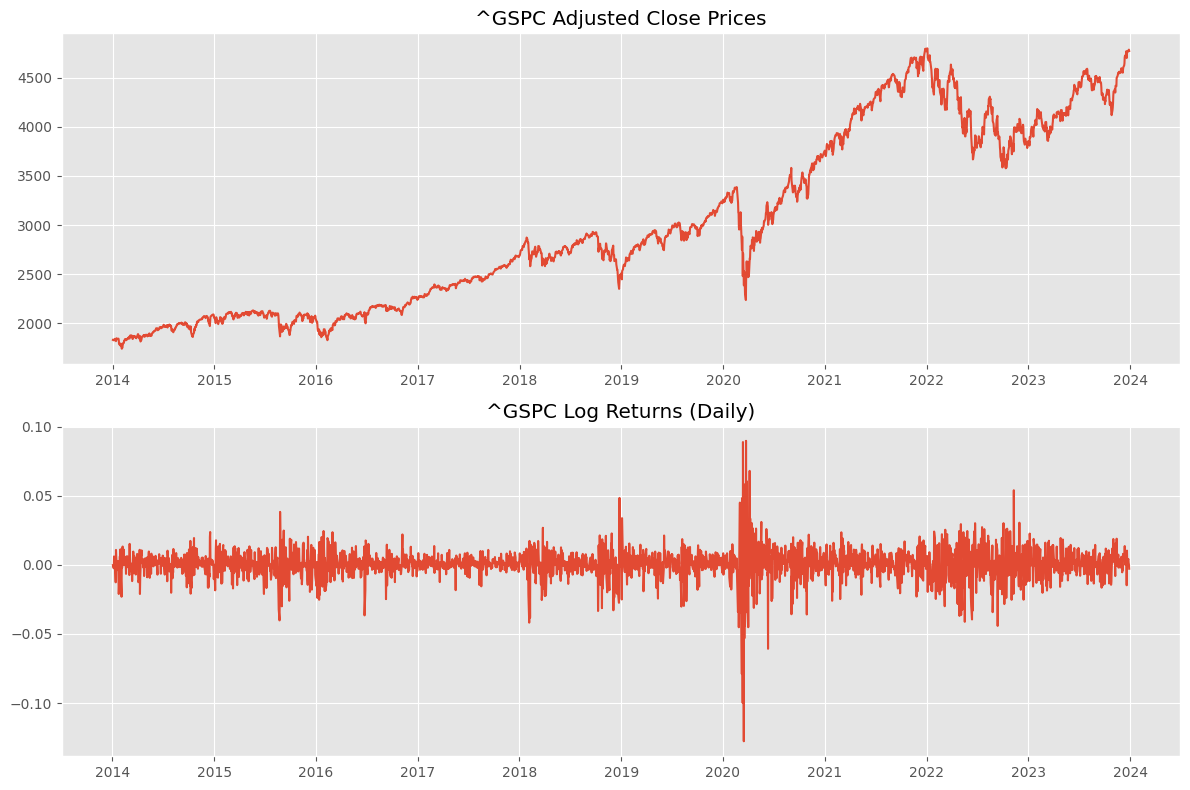

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(prices)
ax[0].set_title(f"{ticker} Adjusted Close Prices")

ax[1].plot(log_returns)
ax[1].set_title(f"{ticker} Log Returns (Daily)")

plt.tight_layout()
plt.show()


In [ ]:
# dicky fuller adf test
aadf_result = adfuller(prices)
print(f'ADF Statistic: {aadf_result[0]:.4f}')
print(f'p-value: {aadf_result[1]:.4f}')

if aadf_result[1] > 0.05:
    print("Result: Fail to reject H0. The price series is Non-Stationary (Consistent with Random Walk).")
else:
    print("Result: Reject H0. The series is Stationary.")


ADF Statistic: -0.3175
p-value: 0.9230
Result: Fail to reject H0. The price series is Non-Stationary (Consistent with Random Walk).


In [ ]:
# lhung test related (autocorelation)
lb_test = acorr_ljungbox(log_returns, lags=[10], return_df=True)
print(lb_test)

p_val = lb_test['lb_pvalue'].values[0]
if p_val > 0.05:
    print("Result: No significant autocorrelation in returns (Consistent with Random Walk).")
else:
    print("Result: Significant autocorrelation detected (Predictable patterns may exist).")


       lb_stat     lb_pvalue
10  267.371125  1.197611e-51
Result: Significant autocorrelation detected (Predictable patterns may exist).


In [ ]:
# variance test ratio
for lag in [2, 5, 10]:
    vr = VarianceRatio(prices, lags=lag)
    print(f"\nLag {lag} Variance Ratio Test:")
    print(f"VR: {vr.vr:.4f} | p-value: {vr.pvalue:.4f}")



Lag 2 Variance Ratio Test:
VR: 0.9054 | p-value: 0.0452

Lag 5 Variance Ratio Test:
VR: 0.8852 | p-value: 0.2685

Lag 10 Variance Ratio Test:
VR: 0.8626 | p-value: 0.3731


In [ ]:
def get_hurst_exponent(time_series, max_lag=20):
    lags = range(2, max_lag)
    # Calculate the variance of the difference for each lag
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # Calculate the slope of the log plot
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

h = get_hurst_exponent(prices.values)
print(f"Hurst Exponent: {h:.4f}")

Hurst Exponent: 0.4848


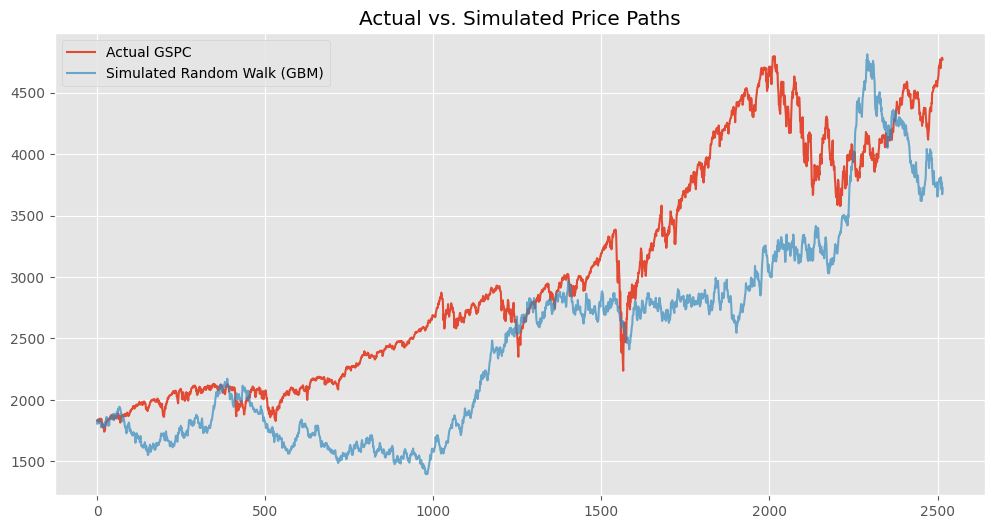

In [ ]:
# Simulate GBM
mu = log_returns.mean()
sigma = log_returns.std()
n_days = len(prices)
s0 = prices.iloc[0].item() # Convert s0 to a scalar

# Generate paths
sim_returns = np.random.normal(mu, sigma, n_days)
sim_prices = s0 * np.exp(np.cumsum(sim_returns))

plt.figure(figsize=(12, 6))
plt.plot(prices.values, label='Actual GSPC')
plt.plot(sim_prices, label='Simulated Random Walk (GBM)', alpha=0.7)
plt.legend()
plt.title("Actual vs. Simulated Price Paths")
plt.show()